# Данные

Сначала подготовим смешанный датасет, указав тип каждого из определений: 

 - "0" - это формальное определение
 
 - "1" - определение-перечисление
 
 - "2" - неформальное определение

## Шаблоны для определений-перечислений

In [1]:
import spacy

nlp = spacy.load('ru2')
nlp.add_pipe(nlp.create_pipe('sentencizer'), first=True)

Сначала расшифруем названия частей речи:

In [2]:
pos_tags = ["NOUN", "ADJ", "ADP", "VERB", "CCONJ", "PRON", "ADV", "DET", "NUM", "PROPN", "SCONJ", "X", "AUX"]

for tag in pos_tags:
    print(tag, spacy.explain(tag))

NOUN noun
ADJ adjective
ADP adposition
VERB verb
CCONJ coordinating conjunction
PRON pronoun
ADV adverb
DET determiner
NUM numeral
PROPN proper noun
SCONJ subordinating conjunction
X other
AUX auxiliary


Объединим оба вида союзов в один; объединим служебные части речи ("AUX"), междометия("INTJ"), частицы("PART") и неопределённые ("X") междометия("INTJ"); присоединим имена собственные к существительным. Сопоставим каждому типу обозначение:

In [3]:
symb = {"NOUN" : "N", "ADJ" : "ADJ", "ADP" : "ADP", "VERB" : "V", 
         "CCONJ" : "C", "PRON" : "P", "ADV" : "ADV", "DET" : "D", 
         "NUM" : "NUM", "PROPN" : "N", "SCONJ" : "C", "X" : "X", 
         "AUX" : "X", "PUNCT" : "PUNCT"}

numb = {"NOUN" : 1, "ADJ" : 2, "ADP" : 3, "VERB" : 4, 
        "CCONJ" : 5, "PRON" : 6, "ADV" : 7, "DET" : 8, 
        "NUM" : 9, "PROPN" : 1, "SCONJ" : 5, "X" : 10, 
        "AUX" : 10, "PUNCT" : 11}

In [4]:
import re

patterns = [r'\b(PUNCT)?(N(PUNCT|C)+)*N\b', r'\b(PUNCT)?(ADJ(PUNCT|C)+)*ADJ\b', 
            r'\b(PUNCT)?(ADJN(PUNCT|C)+)*ADJN\b', r'\b(PUNCT)?(N{1,2}(PUNCT|C)+)*N{1,2}\b', 
            r'\b(PUNCT)?((ADJ)?N(PUNCT|C)+)*(ADJ)?N\b', r'\b(PUNCT)?(V(PUNCT|C)+)*V\b']

## Подготовка датасета

In [5]:
import pandas as pd

file1 = 'test_set_002.csv'

data = pd.read_csv(file1, delimiter=',')

print(data.shape)
data.head(5)

(26861, 3)


,defs,word,len
0,колпак на лампе,абажур,15
1,настоятель католического монастыря,аббат,34
2,католический священник,аббат,22
3,католический монастырь,аббатство,22
4,слово из первых букв,аббревиатура,20


In [6]:
del data['len']

In [7]:
new_col = []
num_arrays = []

max_code_len = 0

for sentence in data['defs']:
    doc = nlp(sentence)
    curr_str = ""
    curr_arr = []
    
    for i in range(len(doc)):
        word = doc[i]
        pos_tag = word.pos_
        if pos_tag not in symb:
            curr_str += "X"
            curr_arr.append(numb["X"])
            continue
        curr_str += symb[pos_tag]
        curr_arr.append(numb[pos_tag])
        
    new_col.append(curr_str)
    num_arrays.append(curr_arr)
    
    if len(curr_arr) >= max_code_len:
        max_code_len = len(curr_arr)

In [8]:
data["encoded defs"] = new_col
data["code array"] = num_arrays
data.head()

,defs,word,encoded defs,code array
0,колпак на лампе,абажур,NADPN,"[1, 3, 1]"
1,настоятель католического монастыря,аббат,NADJN,"[1, 2, 1]"
2,католический священник,аббат,ADJN,"[2, 1]"
3,католический монастырь,аббатство,ADJN,"[2, 1]"
4,слово из первых букв,аббревиатура,NADPADJN,"[1, 3, 2, 1]"


In [9]:
classes = []

for code in data["encoded defs"]:
    flag = False
    for pattern in patterns:
        if re.fullmatch(pattern, code) and not flag:
            classes.append(1)
            flag = True
    if not flag:
        classes.append(0)
    
data["class"] = classes
data.head(20)

,defs,word,encoded defs,code array,class
0,колпак на лампе,абажур,NADPN,"[1, 3, 1]",0
1,настоятель католического монастыря,аббат,NADJN,"[1, 2, 1]",0
2,католический священник,аббат,ADJN,"[2, 1]",1
3,католический монастырь,аббатство,ADJN,"[2, 1]",1
4,слово из первых букв,аббревиатура,NADPADJN,"[1, 3, 2, 1]",0
5,сокращение,аббревиатура,N,[1],1
6,искажение изображения,аберрация,NN,"[1, 1]",1
7,отдельный фрагмент текста,абзац,ADJNN,"[2, 1, 1]",0
8,текст с красной строки,абзац,NADPADJN,"[1, 3, 2, 1]",0
9,поступающий в университет,абитуриент,VADPN,"[4, 3, 1]",0


In [10]:
file2 = '004_human_set_3000.csv'

human_data = pd.read_csv(file2, comment='#')
human_data.head()

,word,defs
0,абажур,верхняя часть лампы
1,абажур,часть лампы
2,абонемент,"это карточка, которая позволяет тебе ходить в ..."
3,абрикос,маленький оранжевый фрукт
4,абрикос,фрукт


In [11]:
codes = []
arrays = []

for sentence in human_data['defs']:
    doc = nlp(sentence)
    curr_str = ""
    curr_arr = []
    
    for i in range(len(doc)):
        word = doc[i]
        pos_tag = word.pos_
        if pos_tag not in symb:
            curr_str += "X"
            curr_arr.append(numb["X"])
            continue
        curr_str += symb[pos_tag]
        curr_arr.append(numb[pos_tag])
        
    codes.append(curr_str)
    arrays.append(curr_arr)
    
    if len(curr_arr) >= max_code_len:
        max_code_len = len(curr_arr)
    
human_data["encoded defs"] = codes
human_data["code array"] = arrays
human_data.head()

,word,defs,encoded defs,code array
0,абажур,верхняя часть лампы,ADJNN,"[2, 1, 1]"
1,абажур,часть лампы,NN,"[1, 1]"
2,абонемент,"это карточка, которая позволяет тебе ходить в ...",PNPUNCTPVPVADPNCXVDNADPN,"[6, 1, 11, 6, 4, 6, 4, 3, 1, 5, 10, 4, 8, 1, 3..."
3,абрикос,маленький оранжевый фрукт,ADJADJN,"[2, 2, 1]"
4,абрикос,фрукт,N,[1]


In [12]:
human_classes = []

for code in human_data["encoded defs"]:
    flag = False
    for pattern in patterns:
        if re.fullmatch(pattern, code) and not flag:
            human_classes.append(1)
            flag = True
    if not flag:
        human_classes.append(2)
    
human_data["class"] = human_classes
human_data.head(20)

,word,defs,encoded defs,code array,class
0,абажур,верхняя часть лампы,ADJNN,"[2, 1, 1]",2
1,абажур,часть лампы,NN,"[1, 1]",1
2,абонемент,"это карточка, которая позволяет тебе ходить в ...",PNPUNCTPVPVADPNCXVDNADPN,"[6, 1, 11, 6, 4, 6, 4, 3, 1, 5, 10, 4, 8, 1, 3...",2
3,абрикос,маленький оранжевый фрукт,ADJADJN,"[2, 2, 1]",2
4,абрикос,фрукт,N,[1],1
5,абрикоч,фрукт похожий на персик но меньше,NADJADPADJCNUM,"[1, 2, 3, 2, 5, 9]",2
6,абсцисс,ось ординат,NN,"[1, 1]",1
7,авария,когда сталкиваются два транспортных средства,CVNUMADJN,"[5, 4, 9, 2, 1]",2
8,авиабилет,"я покупаю его, чтобы полететь в другую страну",PVPPUNCTCVADPADJN,"[6, 4, 6, 11, 5, 4, 3, 2, 1]",2
9,авианосец,"корабль, который переносит самолеты и вертолеты",NPUNCTPVNCN,"[1, 11, 6, 4, 1, 5, 1]",2


In [13]:
mix_data = pd.concat([data, human_data], sort=True)

mix_data.head()

,class,code array,defs,encoded defs,word
0,0,"[1, 3, 1]",колпак на лампе,NADPN,абажур
1,0,"[1, 2, 1]",настоятель католического монастыря,NADJN,аббат
2,1,"[2, 1]",католический священник,ADJN,аббат
3,1,"[2, 1]",католический монастырь,ADJN,аббатство
4,0,"[1, 3, 2, 1]",слово из первых букв,NADPADJN,аббревиатура


Перемешаем строчки:

In [14]:
mix_data = mix_data.sample(frac=1).reset_index(drop=True)
mix_data.head()

,class,code array,defs,encoded defs,word
0,0,"[1, 3, 2, 1]",поворот вокруг горизонтальной оси,NADPADJN,переворот
1,0,"[1, 1, 1]",процесс принятия пищи,NNN,еда
2,0,"[1, 3, 6, 11, 5, 1, 2, 1, 11, 1]",привнесение во что-либо элементов сценического...,NADPPPUNCTCNADJNPUNCTN,театрализация
3,0,"[1, 5, 7, 8, 1, 11, 4, 7, 11, 7, 11, 4, 7, 2, ...","руководитель или вообще любой человек, действу...",NCADVDNPUNCTVADVPUNCTADVPUNCTVADVADJNADPDPUNCTCN,диктатор
4,0,"[1, 11, 4, 1, 11, 2, 1, 1]","мастер, разрабатывающий оружие, различные сист...",NPUNCTVNPUNCTADJNN,оружейник


In [15]:
mix_data.to_csv('mixed_dataset.csv')

# Обучение LSTM-сети

In [16]:
import numpy as np

train, test = np.split(mix_data, [int(.7*len(mix_data))])
print(train.shape)
print(test.shape)

(20829, 5)
(8927, 5)


In [17]:
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences

nb_classes = 3

y_train = utils.to_categorical(train["class"], nb_classes)

In [18]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [19]:
x_train = pad_sequences(train["code array"], maxlen=max_code_len)

In [20]:
x_train

array([[ 0,  0,  0, ...,  3,  2,  1],
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  1, 11,  1],
       ...,
       [ 0,  0,  0, ...,  1,  2,  1],
       [ 0,  0,  0, ...,  3,  8,  1],
       [ 0,  0,  0, ...,  1,  3,  1]])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

max_numb_val = 11

model_lstm = Sequential()
model_lstm.add(Embedding(max_numb_val + 1, 32, input_length=max_code_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(3, activation='softmax'))

In [22]:
model_lstm.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

In [23]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 32)            384       
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 3,571
Trainable params: 3,571
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_lstm_save_path = 'model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                           monitor='val_accuracy',
                                           batch_size=32,
                                           save_best_only=True,
                                           verbose=1)

In [25]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
586/586 [==============================] - 27s 40ms/step - loss: 0.5114 - accuracy: 0.8369 - val_loss: 0.2479 - val_accuracy: 0.9232

Epoch 00001: val_accuracy improved from -inf to 0.92319, saving model to model_lstm.h5
Epoch 2/5
586/586 [==============================] - 35s 60ms/step - loss: 0.2341 - accuracy: 0.9190 - val_loss: 0.2297 - val_accuracy: 0.9227

Epoch 00002: val_accuracy did not improve from 0.92319
Epoch 3/5
586/586 [==============================] - 37s 63ms/step - loss: 0.2125 - accuracy: 0.9261 - val_loss: 0.1998 - val_accuracy: 0.9294

Epoch 00003: val_accuracy improved from 0.92319 to 0.92943, saving model to model_lstm.h5
Epoch 4/5
586/586 [==============================] - 37s 64ms/step - loss: 0.1931 - accuracy: 0.9329 - val_loss: 0.1947 - val_accuracy: 0.9342

Epoch 00004: val_accuracy improved from 0.92943 to 0.93423, saving model to model_lstm.h5
Epoch 5/5
586/586 [==============================] - 37s 64ms/step - loss: 0.1771 - accuracy: 0.9376 -

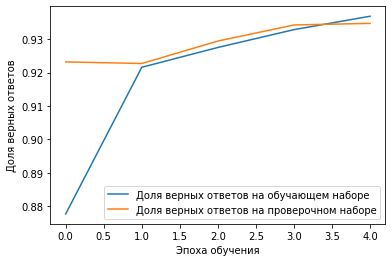

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Оценка качества модели

In [27]:
y_test = utils.to_categorical(test["class"], nb_classes)
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [28]:
x_test = pad_sequences(test["code array"], maxlen=max_code_len)
x_test

array([[ 0,  0,  0, ...,  8,  1,  1],
       [ 0,  0,  0, ...,  1, 11,  1],
       [ 0,  0,  0, ...,  1,  8,  1],
       ...,
       [ 0,  0,  0, ...,  4,  3,  1],
       [ 0,  0,  0, ..., 11,  3,  1],
       [ 0,  0,  0, ..., 11,  2,  1]])

In [29]:
model_lstm.load_weights(model_lstm_save_path)
model_lstm.evaluate(x_test, y_test, verbose=1)

279/279 [==============================] - 2s 9ms/step - loss: 0.1838 - accuracy: 0.9318


[0.18379750847816467, 0.9317799806594849]